### 19. A QUICK LOOK AT MACHINE LEARNING

In [1]:
def minkowskiDist(v1, v2, p):
    """Assumes v1 and v2 are equal-length arrays of numbers
    Returns Minkowski distance of order p between v1 and v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1.0/p)

In [4]:
import pylab
class Animal(object):
    def __init__(self, name, features):
        """Assumes name a string; features a list of numbers"""
        self.name = name
        self.features = pylab.array(features)
    def getName(self):
        return self.name
    def getFeatures(self):
        return self.features
    def distance(self, other):
        """Assumes other an animal
        Returns the Euclidean distance between feature vectors
        of self and other"""
        return minkowskiDist(self.getFeatures(), other.getFeatures(), 2)

In [5]:
def compareAnimals(animals, precision):
    """Assumes animals is a list of animals, precision an int >= 0
    Builds a table of Euclidean distance between each animal"""
    #Get labels for columns and rows
    columnLabels = []
    for a in animals:
        columnLabels.append(a.getName())
    rowLabels = columnLabels[:]
    tableVals = []
    #Get distances between pairs of animals
    #For each row
    for a1 in animals:
        row = []
        #For each column
        for a2 in animals:
            if a1 == a2:
                row.append('--')
            else:
                distance = a1.distance(a2)
                row.append(str(round(distance, precision)))
        tableVals.append(row)
    #Produce table
    table = pylab.table(rowLabels = rowLabels,
            colLabels = columnLabels,
            cellText = tableVals,
            cellLoc = 'center',
            loc = 'center',
            colWidths = [0.2]*len(animals))
            
    table.scale(1, 2.5)
    pylab.axis('off') #Don't display x and y-axes
    pylab.savefig('distances')

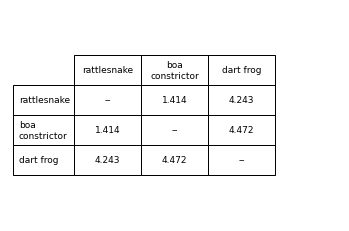

In [6]:
rattlesnake = Animal('rattlesnake', [1,1,1,1,0])
boa = Animal('boa\nconstrictor', [0,1,0,1,0])
dartFrog = Animal('dart frog', [1,0,1,0,4])
animals = [rattlesnake, boa, dartFrog]
compareAnimals(animals, 3)

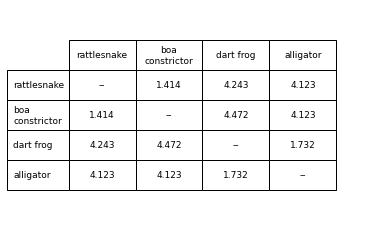

In [8]:
alligator = Animal('alligator', [1,1,0,1,4])
animals.append(alligator)
compareAnimals(animals, 3)

In [9]:
class Example(object):
    def __init__(self, name, features, label = None):
        #Assumes features is an array of numbers
        self.name = name
        self.features = features
        self.label = label
    def dimensionality(self):
        return len(self.features)
    def getFeatures(self):
        return self.features[:]
    def getLabel(self):
        return self.label
    def getName(self):
        return self.name
    def distance(self, other):
        return minkowskiDist(self.features, other.getFeatures(), 2)
    def __str__(self):
        return self.name +':'+ str(self.features) + ':' + str(self.label)

In [10]:
class Cluster(object):
    def __init__(self, examples, exampleType):
        """Assumes examples is a list of example of type exampleType"""
        self.examples = examples
        self.exampleType = exampleType
        self.centroid = self.computeCentroid()
    def update(self, examples):
        """Replace the examples in the cluster by new examples
        Return how much the centroid has changed"""
        oldCentroid = self.centroid
        self.examples = examples
        if len(examples) > 0:
            self.centroid = self.computeCentroid()
            return oldCentroid.distance(self.centroid)
        else:
            return 0.0
    def members(self):
        for e in self.examples:
            yield e
    def size(self):
        return len(self.examples)
    def getCentroid(self):
        return self.centroid
    def computeCentroid(self):
        dim = self.examples[0].dimensionality()
        totVals = pylab.array([0.0]*dim)
        for e in self.examples:
            totVals += e.getFeatures()
        centroid = self.exampleType('centroid',
        totVals/float(len(self.examples)))
        return centroid
    def variance(self):
        totDist = 0.0
        for e in self.examples:
            totDist += (e.distance(self.centroid))**2
        return totDist**0.5
    def __str__(self):
        names = []
        for e in self.examples:
            names.append(e.getName())
        names.sort()
        result = 'Cluster with centroid '\
        + str(self.centroid.getFeatures()) + ' contains:\n '
        for e in names:
            result = result + e + ', '
        return result[:-2]

In [13]:
def kmeans(examples, exampleType, k, verbose):
    """Assumes examples is a list of examples of type exampleType,
    k is a positive int, verbose is a Boolean
    Returns a list containing k clusters. If verbose is
    True it prints result of each iteration of k-means"""
    #Get k randomly chosen initial centroids
    initialCentroids = random.sample(examples, k)
    #Create a singleton cluster for each centroid
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e], exampleType))
    #Iterate until centroids do not change
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1
        #Create a list containing k distinct empty lists
        newClusters = []
        for i in range(k):
            newClusters.append([])
        #Associate each example with closest centroid
        for e in examples:
            #Find the centroid closest to e
            smallestDistance = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].getCentroid())
            if distance < smallestDistance:
                smallestDistance = distance
                index = i
            #Add e to the list of examples for the appropriate cluster
            newClusters[index].append(e)

            #Upate each cluster; check if a centroid has changed
            converged = True
            for i in range(len(clusters)):
                if clusters[i].update(newClusters[i]) > 0.0:
                    converged = False
            if verbose:
                print('Iteration #' + str(numIterations))
            for c in clusters:
                print(c)
            print('') #add blank line
    return clusters

In [14]:
def dissimilarity(clusters):
    totDist = 0.0
    for c in clusters:
        totDist += c.variance()
    return totDist

def trykmeans(examples, exampleType, numClusters, numTrials,
    verbose = False):
    """Calls kmeans numTrials times and returns the result with the
    lowest dissimilarity"""

    best = kmeans(examples, exampleType, numClusters, verbose)
    minDissimilarity = dissimilarity(best)
    for trial in range(1, numTrials):
        clusters = kmeans(examples, exampleType, numClusters, verbose)
    currDissimilarity = dissimilarity(clusters)
    if currDissimilarity < minDissimilarity:
        best = clusters
        minDissimilarity = currDissimilarity
    return best

In [15]:
def genDistribution(xMean, xSD, yMean, ySD, n, namePrefix):
    samples = []
    for s in range(n):
        x = random.gauss(xMean, xSD)
        y = random.gauss(yMean, ySD)
        samples.append(Example(namePrefix+str(s), [x, y]))
    return samples
def plotSamples(samples, marker):
    xVals, yVals = [], []
    for s in samples:
        x = s.getFeatures()[0]
        y = s.getFeatures()[1]
        pylab.annotate(s.getName(), xy = (x, y),
    xytext = (x+0.13, y-0.07),
    fontsize = 'x-large')
    xVals.append(x)
    yVals.append(y)
    pylab.plot(xVals, yVals, marker)

def contrivedTest(numTrials, k, verbose):
    random.seed(0)
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean, xSD, yMean, ySD, n, '1.')
    plotSamples(d1Samples, 'b^')
    d2Samples = genDistribution(xMean+3, xSD, yMean+1, ySD, n, '2.')
    plotSamples(d2Samples, 'ro')
    clusters = trykmeans(d1Samples + d2Samples, Example, k,
    numTrials, verbose)
    print ('Final result')
    for c in clusters:
        print('', c)

In [ ]:
import random
contrivedTest(1, 2, True)

In [ ]:
contrivedTest(40, 2, False)

In [26]:
def readMammalData(fName):
    dataFile = open(fName, 'r')
    numFeatures = 0
    #Process lines at top of file
    for line in dataFile: #Find number of features
        if line[0:6] == '#Label': #indicates end of features
            break
        if line[0:5] != '#Name':
            numFeatures += 1
    featureVals = []

    #Produce featureVals, speciesNames, and labelList
    featureVals, speciesNames, labelList = [], [], []
    for i in range(numFeatures):
        featureVals.append([])

    #Continue processing lines in file, starting after comments
    for line in dataFile:
        dataLine = string.split(line[:-1], ',') #remove newline; then split
        speciesNames.append(dataLine[0])
        classLabel = float(dataLine[-1])
        labelList.append(classLabel)
        for i in range(numFeatures):
            featureVals[i].append(float(dataLine[i+1]))

    #Use featureVals to build list containing the feature vectors
    #for each mammal
    featureVectorList = []
    for mammal in range(len(speciesNames)):
        featureVector = []
        for feature in range(numFeatures):
            featureVector.append(featureVals[feature][mammal])
        featureVectorList.append(featureVector)
    return featureVectorList, labelList, speciesNames

In [27]:
def buildMammalExamples(featureList, labelList, speciesNames):
    examples = []
    for i in range(len(speciesNames)):
        features = pylab.array(featureList[i])
        example = Example(speciesNames[i], features, labelList[i])
        examples.append(example)
    return examples

def testTeeth(numClusters, numTrials):
    features, labels, species = readMammalData('/Users/kassayebelay/Desktop/Python/IntrotoComputationwithPython/dentalFormulas.txt')
    examples = buildMammalExamples(features, labels, species)
    bestClustering =\
    trykmeans(examples, Example, numClusters, numTrials)
    for c in bestClustering:
        names = ''
        for p in c.members():
            names += p.getName() + ', '
        print('\n', names[:-2]) #remove trailing comma and space
        herbivores, carnivores, omnivores = 0, 0, 0
        for p in c.members():
            if p.getLabel() == 0:
                herbivores += 1
            elif p.getLabel() == 1:
                carnivores += 1
            else:
                omnivores += 1
        print(herbivores, 'herbivores,', carnivores, 'carnivores,',omnivores, 'omnivores')

In [28]:
testTeeth(3, 20)

NameError: name 'string' is not defined

In [29]:
def scaleFeatures(vals):
    """Assumes vals is a sequence of numbers"""
    result = pylab.array(vals)
    mean = sum(result)/float(len(result))
    result = result - mean
    sd = stdDev(result)
    result = result/sd
    return result